<img src="img/bigsem.png" width="40%" align="right">
<img src="img/logo_wiwi.png" width="20%" align="left">





<br><br><br><br>

## Decision-Focused Analytics
**Winter Term 2021/22**


# 4. Joint Distributions and Probabilistic ML Models for Decision-Making under Uncertainty

<img src="img/decision_analytics_logo.png" width="17%" align="right">


<br>

<br>
<br>

**J-Prof. Dr. Michael Römer |  Decision Analytics Group**
                                                    


In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from numba import vectorize
import pandas as pd
import mip
from mip import maximize


## Overview: This Meeting

Today, we consider the following topics:
- relations / dependencies between uncertain quantities and their impact in 
  - decision making under uncertainty
  - optimization under uncertainty
- simple-to-use tools for probabilistic prediction / machine learning
- a case study in which a probabilistic predicition model is embedded in an optimization model

## In Case you are in Colab

Please run

%pip install ngboost

%pip install gurobi

%pip install janos

# Interrelated Uncertain Quantities

**We will consider:**
- Case study emphasizing the importance of modelling relations in data
- modelling relations with a multivariate normal distribution

## Case Study: Machine Shutdowns


Let us assume that your company is willing to buy a new processing machine for your main production line. The machine is highly efficient, but somewhat sensitive to the room climate: Whenever a certain temperature and humidity threshold is exceeded, it automatically turns itself down for one hour.

To be more concrete, the machine turns itself off if:
- the temperature is $\geq$ 30 degrees Celsius

**and at the same time**
- the humidity is $\geq$ 50 \%

You now ask yourself what is the expected shutdown rate (the fraction of hours the machine would shut down) in your factory.



## Case Study: Historical Data

Fortunately, you have collected 1000 hourly data points from your factory with temperature and humidity data:

- temperatures
- humidities

In [88]:
temperatures = np.loadtxt('data/temperatures.txt')
humidities = np.loadtxt('data/humidities.txt')


**Task:**
- Create a Histogram of both data sets
- Fit a Distribution for each data set (assuming that both data sets are i.i.d.)
- Use Monte-Carlo Simulation to estimate the shutdown rate of the machine



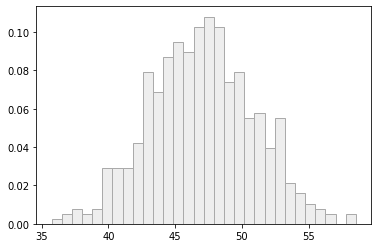

In [58]:
data = humidities

count, bins, ignored = plt.hist(data, bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA")

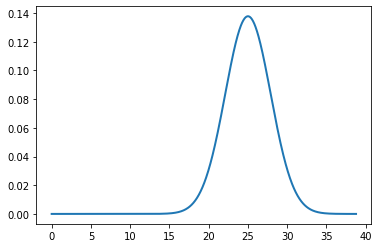

In [39]:
from scipy.stats import norm
params = norm.fit(temperatures) #floc=0 forbids shifting on the x-axis

dist_normal_temperature = norm(*params)

xx = np.linspace(0,np.max(temperatures)+5, 1000)
plt.plot(xx, dist_normal_temperature.pdf(xx), linewidth=2);

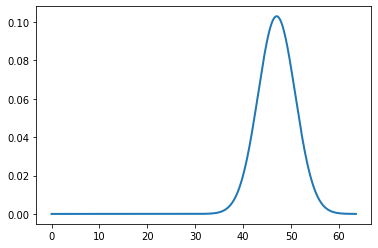

In [40]:
from scipy.stats import norm
params = norm.fit(humidities) #floc=0 forbids shifting on the x-axis

dist_normal_humidity = norm(*params)

xx = np.linspace(0,np.max(humidities)+5, 1000)
plt.plot(xx, dist_normal_humidity.pdf(xx), linewidth=2);

In [63]:
samples_temperature = dist_normal_temperature.rvs(10000)
samples_humidity = dist_normal_humidity.rvs(10000)

In [64]:
shutdowns = (samples_temperature >= 30) * (samples_humidity >= 50)
np.mean(shutdowns)

0.0087

In [67]:
shutdowns = (temperatures >= 30) * (humidities >= 50)
np.mean(shutdowns)

0.026

## But Wait: We Deal with Relations!

Let us have a first have a look at the data:


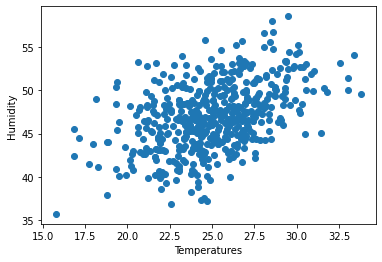

In [15]:
plt.scatter(temperatures,humidities)
plt.xlabel("Temperatures")
plt.ylabel("Humidity");

...we see a clear relationship here!

## Do these Relations Have an Impact?


**Task:**
- assume that the historical values were collected at the same points in time
- use the historical values to compute the shutdown rate if the machine had already been operating!

## Quantifying Relations: Correlation and Covariance


We can quantify by computing:
- the correlation coefficient (gives us a matrix in which
  the coefficient appears in upper right and lower left part of the matrix)




In [16]:
np.corrcoef(temperatures,humidities)

array([[1.        , 0.45421731],
       [0.45421731, 1.        ]])


- the covariance matrix


In [20]:
cov_matrix = np.cov(temperatures,humidities)
cov_matrix

array([[ 8.39845119,  5.10205791],
       [ 5.10205791, 15.02326096]])

Here the matrix gives us:
- upper left: the variance of the temperatures
- lower right: the variance of the humidities
- upper right and lower left: the covariance 

## Multivariate Normal Distribution

Given 
- the observation that both temperature and 

we can use a **multivariate normal distribution** to model the joint distribution of temperature and humidity.

The multivariate normal distribution takes two parameters:
- the expected values of the normal random variables
- the covariance matrix


In [22]:
from scipy.stats import multivariate_normal

mv_norm = multivariate_normal(mean = [temperatures.mean(), humidities.mean()], cov = cov_matrix)



## Sampling from the Multivariate Normal Distribution

Let us sample from the multivariate normal distribution to compare the plot with our historical data:




In [68]:
multivariate_samples = mv_norm.rvs(100000)
print(multivariate_samples[0:3])

[[22.30966049 46.5706744 ]
 [22.89794553 45.02738235]
 [24.91137322 46.11066349]]


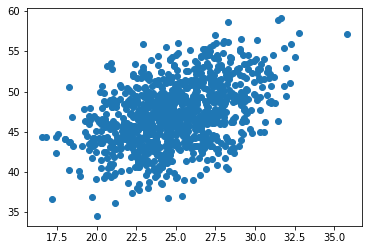

In [28]:
plt.scatter(multivariate_samples.T[0],multivariate_samples.T[1]);

In [71]:
shutdowns = (multivariate_samples.T[0] >= 30) * (multivariate_samples.T[1] >= 50)
np.mean(shutdowns)

0.02438

## Let us Now Simulate with the Multivariate Distribution

**Task**
- Use the multivariate normal distribution for simulating the rate of machine shutdowns
Hint:
- You can either do this in a loop, calling `rvs` in each loop or
- or draw samples in advance and use those samples

# Case Study: The Farmer's Problem

## Case Study: A Farmer's Problem (Deterministic)

- a farmer has 450 acres of farmland and now has to decide how many
  acres to plant with the three crops wheat, corn and beets
- he needs some amount of  each crop for feeding his cattle
- if he harvests less than needed, he can buy crops on the market
- surplus can be sold on the market


| parameter          | unit       | wheat | corn | beets |
|:-------------------|:-----------|-------|------|-------|
| crop yield         | t per acre |   2.5 |    3 |    12 |
| planting costs     | \$ per acre |   150 |  180 |   210 |
| needed for feeding | t          |   200 |  250 |   720 |
| buying price       | \$ per t    |   290 |  260 |    70 |
| selling price      | \$ per t    |   200 |  180 |    45 |

**How much area should the farmer devote to each crop to maximize his profit?**


## Farmer's Problem: Deterministic Model, Compact


**Sets:**
- $I$: the set of crops


**Decision Variables:**
- $x_i$: acres to plant with crop $i$
- $y_i$: tons to buy from crop $i$
- $z_i$: tons to sell from crop $i$


**Parameters:**
- $b$: acres available for planting
- $c_i$: planting cost per acre of $i$
- $d_i$: price for buying a ton of crop $i$ 
- $e_i$: price for selling a ton of crop $i$ 
- $h_i$: yield for crop $i$ in tons per acre
- $o_i$: own demand in tons for crop $i$  



\begin{align*}
        \max \;          \sum_{i \in I}  (-c_i x_i &- d_i y_i + e_i z_i)  \\
	     		 \sum_{i \in I} x_i &\leq b \\
       	     		  h_i x_i + y_i  &= o_i + z_i \qquad \forall i \in I \\
                         x_i \geq 0, y_i &\geq 0, z_i \geq 0  \qquad \forall i \in I
\end{align*}

## Farmer's Problem: Deterministic Model in Python



In [11]:
# Create a new model
m = mip.Model("Farmers_problem_deterministic")

crop_strings=['Wheat','Corn','Beets']

#sets
crops =range(3)

#parameters
area = 450

crop_yield = [2.5, 3, 12]
plant_cost = [150, 180, 210]
needed_for_feeding = [200, 250, 720]
buy_price = [290, 260, 70]
sell_price = [200, 180, 45]

#decision variables
plant =  [m.add_var(name=f"plant{crop}" , lb= 0) for crop in crops]
buy = [m.add_var(name=f"buy{crop}", lb= 0) for crop in crops]
sell =[m.add_var(name=f"sell{crop}", lb= 0) for crop in crops]

m.objective = maximize(sum( -plant_cost[crop]*plant[crop] + sell_price[crop]*sell[crop] - buy_price[crop]*buy[crop] for crop in crops) )

m += sum( plant[crop] for crop in crops ) <= area 

for crop in crops:
    m += crop_yield[crop] * plant[crop] + buy[crop] == needed_for_feeding[crop] + sell[crop] 

## Farmer's Problem: Deterministic Model in Python

Let us solve the model here:

In [12]:
m.optimize()

deterministic_planting_decisions = [plant[crop].x for crop in crops]

for crop in crops:
    print ('Decisions for ' + crop_strings[crop])
    print(f'Planting decision {plant[crop].x}')
    print(f'Buying decision {buy[crop].x}')
    print(f'Selling decision {sell[crop].x}\n')
    
    
print(f'Total Profit: {m.objective_value}' )

Decisions for Wheat
Planting decision 80.0
Buying decision 0.0
Selling decision 0.0

Decisions for Corn
Planting decision 310.0
Buying decision 0.0
Selling decision 680.0

Decisions for Beets
Planting decision 60.0
Buying decision 0.0
Selling decision 0.0

Total Profit: 42000.0


# Extension: Uncertain Crop Yields

## Extension: Uncertain Crop Yields $h_i$


**Crop yields are subject to uncertainty**
- we now assume that crop yields are uncertain
  - we assume that we have a **joint distribution** for yields accounting
    for causal structure
- planting decisions have to be taken before knowing crop yields
- buying and selling can happen after harvesting the crops
- we assume that buying and selling prices are **not** affected by uncertainty

<img width='90%' src='img/farmer_information_structure.png'>

## Extension: Uncertain Crop Yields $h_i$



**Scenario-based representation of uncertainty:**
- we assume that we can represent the joint distribution (a multivariate normal distribution) of the crop
  yields $h_i$ using a set of scenarios $S$ 
- we have then have yield values $h_{is}$ for each scenario $s$
- buying and selling decisions also get a scenario index 

<img width='90%' src='img/farmer_scenarios.png'>


## Extension: Uncertain Crop Yields $h_i$

**Creating samples in Python**
- we now create the multivariate normal distribution and sample from it

In [13]:
from scipy.stats import multivariate_normal
from scipy.stats import norm
import math

# means and covariances are needed for the joint distiribution
crop_yield = [2.5, 3, 12]

covs = [[0.3, 0.3, -0.2],
         [0.3,0.7,-0.2],
         [-0.2,-0.2,2]]



joint_distribution = multivariate_normal(mean = crop_yield, cov = covs)

# Generate some samples from the joint distribution
n_samples = 2000
crop_yield_samples_consistent = joint_distribution.rvs(n_samples).transpose()

joint_distribution.rvs()

array([ 2.97539147,  2.36685394, 13.37949139])

## Structure of the Stochastic Programming Model 

**Model structure**
- the area constraint is a **first-stage constraint**
- the balance constraints are scenario-dependent **second-stage constraints**

<img width='90%' src='img/farmer_model_structure.png'>

- the **objective function** involves the first-stage planting costs and
  the expected value of the second-stage profits



## Case Study: Two-stage Stochastic Programming Model


- new set $S$: scenarios
- the yield parameter gets a scenario index:
  - $h_{is}$: yield for crop $i$ in tons per acre in scenario $s$
-  buying and selling  are now second-stage decisions with scenario indexes: 
  - $y_{is}$: tons to buy from crop $i$ in scenario $s$
  - $z_{is}$: tons to sell from crop $i$ in scenario $s$


\begin{align*}
        \max \;          \sum_{i \in I}  -c_i x_i  + \sum_{s \in S} p_s  &\sum_{i \in I}  (- d_i y_{is} + e_i z_{is})  \\
	     		 \sum_{i \in I} x_i &\leq b \\
       	     		  h_{is} x_i + y_{is}  &= o_i + z_{is} \qquad  \forall i \in I, s \in S \\
                         x_i &\geq 0  \qquad \qquad \forall i \in I \\
			  y_{is} \geq 0, z_{is} &\geq 0  \qquad \qquad  \forall i \in I, s \in S
\end{align*}


## Case Study: Two-stage Stochastic Programming Model in Python



In [17]:
m = mip.Model("Farmers_problem_stochastic")

#sets
n_scenarios = crop_yield_samples_consistent[0].size
scenarios  = np.arange(n_scenarios)
crop_yield = crop_yield_samples_consistent

prob = [1.0/n_scenarios for scenario in scenarios]

#decision variables   
plant =  [m.add_var(name=f"plant{crop}" , lb= 0) for crop in crops]

#second-stage decisions
# buy[crop][scenario]: Be careful since the order of the looping expression is non-intuitive
buy = [[m.add_var(name=f"buy{crop}_{s}", lb= 0) for s in scenarios ]  for crop in crops]

sell = [[ m.add_var(name=f"sell{crop}_{s}", lb= 0) for s in scenarios ]  for crop in crops]

profit = [m.add_var(name="profit", lb= -np.inf) for s in scenarios]

m.objective = maximize ( sum (prob[scenario]*profit[scenario] for scenario in scenarios) )

# area constraint   
m += sum( plant[crop] for crop in crops ) <= area 


#second-stage constraints 
for s in scenarios:
    #computing profit
    m += profit[s] == sum( -plant_cost[crop]*plant[crop] + sell_price[crop]*sell[crop][s] - buy_price[crop]*buy[crop][s] for crop in crops )

    # balance constraints
    for crop in crops:        
        m += crop_yield[crop][s] * plant[crop] + buy[crop][s] == needed_for_feeding[crop] + sell[crop][s]

## Case Study: Two-stage Stochastic Programming Model in Python

Let us solve the model now:

In [18]:
m.optimize()


for crop in crops:
    print(f'Planting decision for {crop_strings[crop]}: {plant[crop].x:0.2f}')

print(f'Expected Profit: {m.objective_value:0.2f}' )

Planting decision for Wheat: 113.67
Planting decision for Corn: 267.08
Planting decision for Beets: 69.25
Expected Profit: 41521.39


# Exercise: The Importance of Properly Accounting for Dependencies in Uncertain Parameters

## The Importance of Properly Accounting for Dependencies in Uncertain Parameters

- as mentioned above, we assume that the crop yield distributions for the different crops are not independent of each other
- as a consequence, we used a multivariate normal distribution to model these dependencies 
- and drew samples from the joint distributions in order to obtain **consistent scenarios**

The following plots should visualize the dependencies between the data sets:



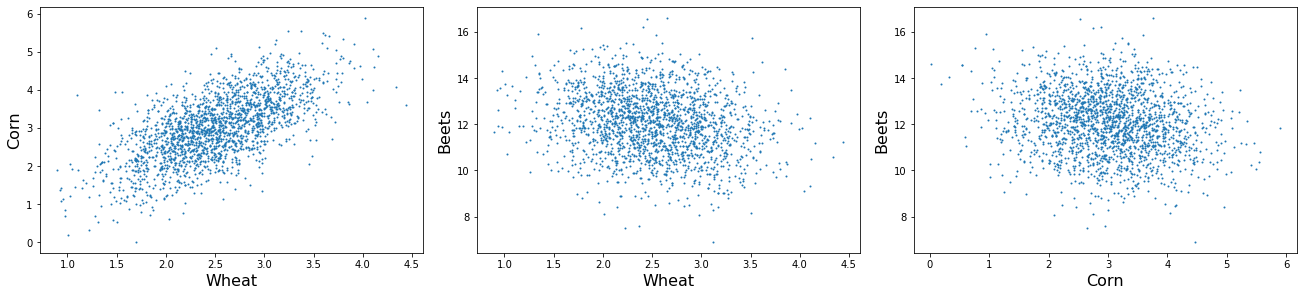

In [22]:
#only for the plots
xx = [0,0,1]
yy = [1,2,2]

crop_strings=['Wheat','Corn','Beets']

fig, axes = plt.subplots(1, len(xx), figsize=(6*len(xx), 4), constrained_layout=True)

for ax_index in range(3):
    axes[ax_index].scatter(crop_yield_samples_consistent[xx[ax_index]],crop_yield_samples_consistent[yy[ax_index]],s=1)
    axes[ax_index].set_xlabel(crop_strings[xx[ax_index]], fontsize=16)
    axes[ax_index].set_ylabel(crop_strings[yy[ax_index]], fontsize=16)
    
#plt.savefig("scatter_crop_yields.pdf",bbox_inches="tight")


## Exercise: What if we Neglect the Dependencies?
- create a set of **inconsistent crop yield samples / scenarios** 
  - hint: you may use the function ``np.random.permutation`` to "shuffle" the sample vectors for wheat, crop and corn (shuffle only "within" one type of crop, of course)
- use the "inconsistent" crop yield for optimization 
- compare those results to the results obtained with the consistent samples. What is the difference?

# Probabilistic Machine Learning Models


## Motivation

In our first week, we 
- discussed how to obtain probability distributions from data
- learned that fitting a single distribution requires the i.i.d. assumption

What if this assumption does not hold?
- we will consider the first data set (data1) later

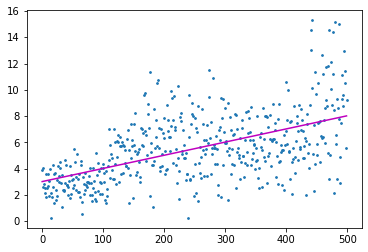

In [87]:

data1 = np.loadtxt('data/data1.txt')
data2 = np.loadtxt('data/data2.txt')
data3 = np.loadtxt('data/data3.txt')

data = data1

xx = range(len(data))

plt.scatter(xx, data, s=3);

z = np.polyfit(xx, data, deg=1) # deg is the degree of the polynomial (1=linear)
p = np.poly1d(z)
plt.plot(xx, p(xx), 'm-');


# Probabilistic Machine Learning Models: Overview


In remainder of this meeting, we  will see how to use Data Science models to handle (certain) non-i.i.d. cases

We will:
- shortly review basic of Machine Learning
- see how to obtain **probabilisitic** predictions 
  - from classification and
  - regression models
  




##  Supervised vs unsupervised learning


**Unsupervised Learning**
- data points only contain features
- the goal is to identify relations / associations between data points
- prominent examples: clustering, market basket analyis


**Supervised Learning**
- "learning from examples"
- each data point contains
  - attributes / features **and**
  - quantities / labels to be predicted



## Supervised Learning: Classification vs Regression

**Classification:**
- categorical labels
- predicting which class / which category

**Regression:**
- (continous) numerical labels
- predicting how much / how many

## Classification: Single Class vs  Probabilities

- in classification, we typically predict the best or **most likely** class or category
- for decision making, it is often useful to know the **probability of each class**
- then, we can consider the outcome of a (probabilistic) classification as a **discrete probability distribution**

Most tools for classification can also output these probabilities
- e.g. in scikit-learn, there is `predict_proba`




## Example: Classifying Cancer Cells

Let us consider a data set with data containing features of breast cancer tumors and their classification as *malignant* or *beningn*. (The data set comes with scikit-learn)


In [24]:
import sklearn
from sklearn.datasets import load_breast_cancer

from sklearn.naive_bayes import GaussianNB
  
data = load_breast_cancer()
label_names = data['target_names']
labels = data['target']
feature_names = data['feature_names']
features = data['data'];

In [25]:
print ("The first features: ", feature_names[0:4])
print ("Labels: " , label_names)

The first features:  ['mean radius' 'mean texture' 'mean perimeter' 'mean area']
Labels:  ['malignant' 'benign']


In [5]:
# For learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


 We split the data into a train- and a test set and train a **naïve Bayes** classifier with scikit-learn to predict the nature of the tumor from the features.
 
 It seems to work pretty well:

In [26]:
train, test, train_labels, test_labels = train_test_split(features, labels,
                                       test_size = 0.33, random_state = 42)
gnb = GaussianNB()
model = gnb.fit(train, train_labels)
predictions = gnb.predict(test)

print(f"The accuray score of our model is: { accuracy_score(test_labels, predictions):0.2f} ")

The accuray score of our model is: 0.94 


This looks pretty good. Do we really need probabilistic forecasts?

## Example: Quantifying Uncertainty

**But what does this mean for a given patient?**
- some cases are very clear, others not!
- it can be very useful if the classifier **quantifies its own uncertainty**
- in scikit-learn we can use the method `predict_proba` to obtain 

In [7]:
probabilistic_predictions = gnb.predict_proba(test)

In [8]:
probabilistic_predictions[0:3]

array([[2.32433733e-09, 9.99999998e-01],
       [1.00000000e+00, 4.28559311e-63],
       [1.00000000e+00, 9.27759495e-11]])

**Let us consider two patient cases with the same prediction (benign)**

Let us consider the first patient:


In [9]:
patient = 0
prediction = predictions[patient]
probability = probabilistic_predictions[patient][prediction]
print(f"The prediction is that the tumor is {label_names[prediction]} with probability {probability:0.2f}")

The prediction is that the tumor is benign with probability 1.00



Now, let us consider the patient with index 8:

In [27]:
patient = 8
prediction = predictions[patient]
probability = probabilistic_predictions[patient][prediction]
print(f"The prediction is that the tumor is {label_names[prediction]} with probability {probability:0.2f}")

The prediction is that the tumor is benign with probability 0.55


The latter patient may thus consider a more detailed investigation...

## Example: Predicting Length-of-stay in Intensive Care Units (ICUs) 

In  a recent master thesis in collaboration with EvKB (Bethel), we probabilistic classification to predict the length of stay of patients in ICU:
- 1 day, 2 days, 3 days, 4 or more days
from patient health metrics
- e.g. heart rate, blood pressure, medication, ...

Along with distributions for emergency cases, we used these predictions for every ICU in a Monte Carlo Simulation 
- for predicting the daily distribution of ICU occupancy
- for supporting decisions regarding elecitive surgeries that lead to ICU stays


## Regression

For regession models, sklearn does not generally provide

What do we mean with probabilitstic regression?

- if $y$ is the (numeric) label and $\textbf{x}=x_1,..x_n$ is a given  feature vector, then a probabilistic regression model gives us a distribution $Y$ that is conditioned on the features: $Y | \textbf{x}$  

In a classical linear regression (based on ordinary least squares (OLS)):
- $Y$ is a **normal distribution** (in this context often called the residual distribution)
- the (point forecast) $y$ is the mean, and the standard deviation $\sigma$ can be estimated from the data
- interestingly, for the case of (simple) linear regression, the OLS estimate is also the so-called maximum likelihood estimator



## Linear Regression: Example Data Set

Let us now consider the data set 1.
- it has 500 data points
- let us assume that they represent weeks



## Linear Regression for the  Example Data Set

We can use the linear regression model from scikit-learn:


In [11]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

- then our labels $y$ are the data points and
- the (time) indexes of the array are the features $x$
  - note that sklearn expects a feature matrix, thus we need to wrap the indexes into a matrix

In [85]:

y_data1 = data1

time_indices = np.arange(1,len(data1)+1)

# note that we create a two-dimensinal array since sklearn expects this
x_data1 = np.expand_dims(time_indices, axis=1)



NameError: name 'data1' is not defined

Now, we can fit the model to the data

In [13]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(x_data1,y_data1)

print ("Intercept: ",linear_model.intercept_ )
print ("Coefficients: ",linear_model.coef_)

Intercept:  3.0092353926972417
Coefficients:  [0.01001925]


And use it for (point) prediction:

In [14]:
linear_model.predict([[600]])

array([9.02078774])

## Generalized Linear Models

(Standard) linear regression is a special case of **generalized linear models** where
- residuals can stem from various distributions from the exponential family
- link functions are used to connect the linear predictor to the expected value of the distribution
- models are estimated based on **maximum likelikhood**

In Python, both scikit-learn and statsmodels provide GLMs, but:
- **both do not provide a convenient way for obtaining the predictive distribution and sampling**


## Generalized Linear Models: Case Study Example

- let us first reproduce the classical linear regression


In [15]:
import statsmodels.api as sm

x_data1_plus_constant = sm.add_constant(x_data1) # we need to add a constant here
model_normal = sm.GLM(y_data1, x_data1_plus_constant, family=sm.families.Gaussian(sm.families.links.identity()))

model_results_normal = model_normal.fit()

print (model_results_normal.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  500
Model:                            GLM   Df Residuals:                      498
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          4.8876
Method:                          IRLS   Log-Likelihood:                -1105.1
Date:                Tue, 11 May 2021   Deviance:                       2434.0
Time:                        15:16:22   Pearson chi2:                 2.43e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0092      0.198     15.195      0.0

## NGBoost

- **N**atural **G**radient **Boost**ing
- provides probilistic prediction (classification **and** regression) with boosting ensembles
- easy-to-use scikit-learn-based API
- state-of-the-art performance 
- returns scipy-stats-like distribution objects


In [84]:
from ngboost import NGBRegressor, distns


ngb_model = NGBRegressor(Dist=distns.Exponential).fit(x_data1, y_data1)

NameError: name 'x_data1' is not defined

In [18]:
x_value_to_predict = 600

feature_matrix_for_prediction = [[x_value_to_predict]] # we need to wrap this into a matrix

point_forecast = ngb_model.predict(feature_matrix_for_prediction)[0]

point_forecast

8.767327442224857

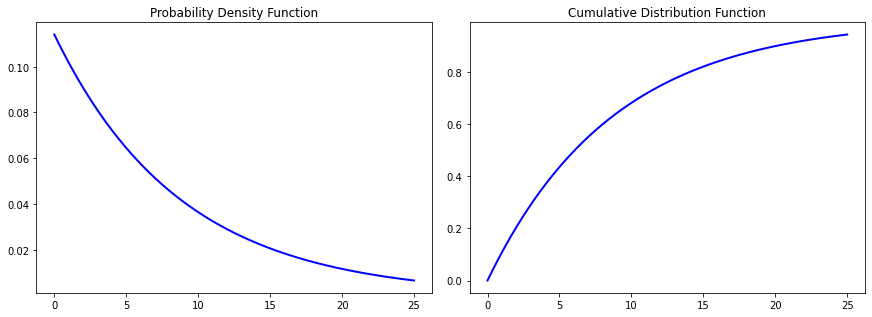

In [19]:
distribution_forecast = ngb_model.pred_dist(feature_matrix_for_prediction)[0]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 4.3), constrained_layout=True)


xx = np.linspace(1E-6, 25, 1000)

ax1.plot(xx, distribution_forecast.pdf(xx), linewidth=2, color='b')
ax1.set_title('Probability Density Function')

ax2.plot(xx, distribution_forecast.cdf(xx), linewidth=2, color='b')
ax2.set_title('Cumulative Distribution Function')


plt.show()



In [20]:
pred_dists_original_data = ngb_model.pred_dist( x_data1 )


negative_ll = -pred_dists_original_data.logpdf(y_data1).mean()
print('Average Negative Log Likelihood', negative_ll)

Average Negative Log Likelihood 2.6369849839712334


In [82]:
# Integrating Prediction and Optimization with JANOS

## Case Study: Will the Student Accept a Scholarship?

The Admission Office of a university wants to offer scholarship to its admitted students in
order to bolster the class profile, in this case by simply maximizing the expected class size.

The Admission Office has collected from previous enrollment years the applicants’ SAT,
GPA, scholarship offered, and the matriculation result, i.e., whether the student accepted
the offer or not. 

This year, suppose the school is issuing 500  offers of admission. Moreover,
suppose the budget available for offered scholarship is \\$1 000 000.
The amount of scholarship that can be assigned to any particular applicant is
\\$0 to \\$25,000. The Admission Office wants to maximize the incoming class size.

## The Data Set

Let us see the historical data set. For each student, it contains:
- the SAT score
- the GPA score
- the scholarship (in $10.000)
- whether the student enrolled

In [8]:
historical_student_data = pd.read_csv("data/college_student_enroll-s1-1.csv")

historical_student_data.head()

,Unnamed: 0,StudentID,SAT,GPA,scholarship,enroll
0,1,1,1507,3.72,1.64,0
1,2,2,1532,3.93,0.52,0
2,3,3,1487,3.77,1.67,0
3,4,4,1259,3.05,1.21,1
4,5,5,1354,3.39,1.65,1


## A Predictive Model

Let us fit a logistic regression model:

In [51]:
X = historical_student_data[["SAT", "GPA", "scholarship"]]
y = historical_student_data[["enroll"]]

scaler_sat = StandardScaler().fit(X[["SAT"]])
scaler_gpa = StandardScaler().fit(X[["GPA"]])
X['SAT_scaled'] = scaler_sat.transform(X[['SAT']])
X['GPA_scaled'] = scaler_gpa.transform(X[['GPA']])
# Then, train the logistic regression model.
prediction_model = LogisticRegression(random_state=0, solver='lbfgs').fit(X[["SAT_scaled", "GPA_scaled", "scholarship"]], y.values.ravel())


## A new Cohort of Applicants

In [90]:
applicants = pd.read_csv("data/admissions500.csv")
applicants['SAT_scaled'] = scaler_sat.transform(applicants[['SAT']])
applicants['GPA_scaled'] = scaler_gpa.transform(applicants[['GPA']])

Let us play with different scholarships

In [93]:
applicants_example_scholarship= applicants
applicants_example_scholarship["scholarship"] = 1.2

In [95]:
applicants_example_scholarship

,StudentID,SAT,GPA,SAT_scaled,GPA_scaled,scholarship
0,1,1289,3.099046,0.015497,-0.267043,1.2
1,2,1016,2.362245,-1.614386,-1.963761,1.2
2,3,1424,3.616878,0.821483,0.925430,1.2
3,4,1261,3.027890,-0.151671,-0.430902,1.2
4,5,1326,3.128963,0.236397,-0.198150,1.2
...,...,...,...,...,...,...
495,496,1342,3.404613,0.331921,0.436623,1.2
496,497,1418,3.609573,0.785661,0.908607,1.2
497,498,1209,3.049335,-0.462125,-0.381517,1.2
498,499,1330,3.256108,0.260278,0.094642,1.2


In [74]:
prediction = prediction_model.predict(applicants_example_scholarship[["SAT_scaled", "GPA_scaled", "scholarship"]])
probabilistic_prediction = prediction_model.predict_proba(applicants_example_scholarship[["SAT_scaled", "GPA_scaled", "scholarship"]])

In [65]:
prediction_model.predict_proba(applicants_example_scholarship[["SAT_scaled", "GPA_scaled", "scholarship"]])[0][1]

0.9989523873734952

## Question: How to allocate the budget?

- the admission office can offer of a total budget of $1 000 000 
- a key feature of this problem: **one of the decision variables affects the prediction**


## A Simplified Model


\begin{align*}
        \max \;          \sum_{i \in A}  y_i  \\
	     		 \sum_{i \in I} x_i &\leq 1,000,000 \qquad(\textrm{Budget})  \\
       	     		  y_i  &= \textit{pred}(s_i, g_i, x_i) \qquad \forall i \in A \\
                             0 \leq &x_i \leq 25,000 \qquad \forall i \in A
\end{align*}

where:

- $A$ is the set of applicants
- $x_i$ is the amount of scholarship offered to student $i$
- $y_i$ is the probability that applicant $i$ will accept the offer
- $\textit{pred}(s_i, g_i, x_i)$ is the (pretrained) prediction function / model
- $s_i$ is the scaled SAT score of applicant $i$
- $g_i$ is the scaled GPA score of applicant $i$

## How can we embed the Prediction Model into the Optimization Model?

- we need to capture the structure of the predictive model in the optimization model
- this is relatively straightforward for linear regression models
- but there exist formulations for embedding a number of different prediction models in optimization models, e.g. for
  - logistic regression
  - neural networks
  - decision trees
- if we have formulate these models by "hand", this becomes be quite tedious



## JANOS:  An Integrated Predictive and Prescriptive Modeling Framework
http://janos.opt-operations.com

Bergman, D., Huang, T., Brooks, P., Lodi, A., and Raghunathan, A. U. (2019). JANOS: An Integrated Predictive and Prescriptive Modeling Framework.

- allows embedding certain `scikit-learn` models into optimization models
- decision variables can serve as features for the predictive models
- the result of the prediction is a special type of decision variable: a **predicted** decision variable

#### In the example:
- the offered scholarship $x_i$ is a predicted decision variable
- the probabiltiy of acceptance $y_i$ is a regular decision variable


## JANOS for our Example: Setting up the Model

In [76]:
from janos import *
m = JModel()

n_admitted = 500 # number of admitted applicants considered for scholarship
scholarships = [0, 2.5] # assumed to be in tens of thousands
budget = 100 # assumed to be in tens of thousands

# Define regular variables
assign_scholarship = m.add_regular_variables([n_admitted], "assign_scholarship")
for app_index in range(n_admitted):
    assign_scholarship[app_index].setContinuousDomain(lower_bound=scholarships[0], upper_bound=scholarships[1])
    assign_scholarship[app_index].setObjectiveCoefficient(0)
    

## JANOS for our Example: Embed the Predicion Model and Define Predicted Variables

In [77]:
# Define predicted variables
# First, we need to create structures of predictive models. In this case, we associate such a structure with an existing / pretrained logistic regression model.
# Each predicted variable must be associated with a OptimizationPredictiveVariable, noting that multiple predicted variables can be associated
# with the same one
logistic_regression_model = OptimizationPredictiveModel(m, pretrained_model=prediction_model,
                                                        feature_names=["SAT_scaled", "GPA_scaled", "scholarship"])

# Now, we could define the predicted decision variables and associate them with the predicted model structure.
enroll_probabilities = m.add_predicted_variables([n_admitted], "enroll_probs")
for app_index in range(n_admitted):
    enroll_probabilities[app_index].setObjectiveCoefficient(1)
    mapping_of_vars = {"scholarship": assign_scholarship[app_index],
                       "SAT_scaled": applicants["SAT_scaled"][app_index],
                       "GPA_scaled": applicants["GPA_scaled"][app_index]}
    enroll_probabilities[app_index].setPM(logistic_regression_model, mapping_of_vars)

## JANOS for our Example: Create the Budget Constraints and Solve

In [81]:
# \sum_i x_i <= BUDGET
scholarship_deployed = Expression()

for app_index in range(n_admitted):
    scholarship_deployed.add_term(assign_scholarship[app_index], 1)

m.add_constraint(scholarship_deployed, "less_equal", budget)
m.add_gurobi_param_settings('TimeLimit',60)
m.solve()



Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TimeLimit to 60.0
   Prev: 3600.0  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 40502 rows, 10500 columns and 85804 nonzeros
Model fingerprint: 0x13ec4d11
Variable types: 1000 continuous, 9500 integer (9500 binary)
Coefficient statistics:
  Matrix range     [1e-13, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e-08, 1e+02]
Presolve removed 39292 rows and 2677 columns
Presolve time: 0.58s
Presolved: 1210 rows, 7823 columns, 22522 nonzeros
Variable types: 403 continuous, 7420 integer (7420 binary)
Found heuristic solution: objective 19

## JANOS for our Example: Print the Results

In [80]:
print("==> X (regular variables values) : ")
for rv_index in range(m.get_number_of_regular_variables()):
    #### Retrives value of regular variable at optimal solution
    print(m.get_regular_variables()[rv_index].VarName, " = ",
          round(m.get_regular_variables()[rv_index].X, m.decimals))

print("==> Y (predicted variables values) : ")
for pv_index in range(m.get_number_of_predicted_variables()):
    #### Retrieves value of predicted variable at optimal solution
    print(m.get_predicted_variables()[pv_index].VarName, " = ",
          round(m.get_predicted_variables()[pv_index].X, m.decimals))

==> X (regular variables values) : 
assign_scholarship[0]  =  0.7
assign_scholarship[1]  =  0.0
assign_scholarship[2]  =  0.0
assign_scholarship[3]  =  0.39
assign_scholarship[4]  =  0.99
assign_scholarship[5]  =  0.0
assign_scholarship[6]  =  1.13
assign_scholarship[7]  =  1.49
assign_scholarship[8]  =  0.74
assign_scholarship[9]  =  0.0
assign_scholarship[10]  =  0.0
assign_scholarship[11]  =  1.02
assign_scholarship[12]  =  0.0
assign_scholarship[13]  =  0.0
assign_scholarship[14]  =  0.62
assign_scholarship[15]  =  0.56
assign_scholarship[16]  =  0.69
assign_scholarship[17]  =  0.0
assign_scholarship[18]  =  0.45
assign_scholarship[19]  =  0.07
assign_scholarship[20]  =  0.0
assign_scholarship[21]  =  0.91
assign_scholarship[22]  =  0.0
assign_scholarship[23]  =  -0.0
assign_scholarship[24]  =  0.67
assign_scholarship[25]  =  0.44
assign_scholarship[26]  =  0.54
assign_scholarship[27]  =  0.0
assign_scholarship[28]  =  1.19
assign_scholarship[29]  =  0.0
assign_scholarship[30]  =  

assign_scholarship[381]  =  0.05
assign_scholarship[382]  =  0.0
assign_scholarship[383]  =  0.04
assign_scholarship[384]  =  0.0
assign_scholarship[385]  =  0.86
assign_scholarship[386]  =  0.46
assign_scholarship[387]  =  0.0
assign_scholarship[388]  =  0.0
assign_scholarship[389]  =  0.04
assign_scholarship[390]  =  0.8
assign_scholarship[391]  =  0.0
assign_scholarship[392]  =  1.01
assign_scholarship[393]  =  1.21
assign_scholarship[394]  =  1.27
assign_scholarship[395]  =  0.0
assign_scholarship[396]  =  0.0
assign_scholarship[397]  =  0.0
assign_scholarship[398]  =  0.0
assign_scholarship[399]  =  0.0
assign_scholarship[400]  =  0.0
assign_scholarship[401]  =  0.0
assign_scholarship[402]  =  0.0
assign_scholarship[403]  =  0.0
assign_scholarship[404]  =  0.0
assign_scholarship[405]  =  0.0
assign_scholarship[406]  =  0.0
assign_scholarship[407]  =  0.0
assign_scholarship[408]  =  0.0
assign_scholarship[409]  =  0.0
assign_scholarship[410]  =  0.61
assign_scholarship[411]  =  0.0

enroll_probs[443]  =  1.0
enroll_probs[444]  =  1.0
enroll_probs[445]  =  0.0
enroll_probs[446]  =  1.0
enroll_probs[447]  =  0.0
enroll_probs[448]  =  1.0
enroll_probs[449]  =  1.0
enroll_probs[450]  =  1.0
enroll_probs[451]  =  1.0
enroll_probs[452]  =  0.0
enroll_probs[453]  =  1.0
enroll_probs[454]  =  0.0
enroll_probs[455]  =  1.0
enroll_probs[456]  =  0.0
enroll_probs[457]  =  1.0
enroll_probs[458]  =  0.97
enroll_probs[459]  =  1.0
enroll_probs[460]  =  1.0
enroll_probs[461]  =  0.0
enroll_probs[462]  =  0.0
enroll_probs[463]  =  1.0
enroll_probs[464]  =  1.0
enroll_probs[465]  =  1.0
enroll_probs[466]  =  0.0
enroll_probs[467]  =  1.0
enroll_probs[468]  =  1.0
enroll_probs[469]  =  1.0
enroll_probs[470]  =  0.0
enroll_probs[471]  =  0.0
enroll_probs[472]  =  1.0
enroll_probs[473]  =  1.0
enroll_probs[474]  =  1.0
enroll_probs[475]  =  1.0
enroll_probs[476]  =  0.0
enroll_probs[477]  =  0.0
enroll_probs[478]  =  1.0
enroll_probs[479]  =  0.0
enroll_probs[480]  =  0.0
enroll_prob

## Integrated Prediction and Optimization with JANOS: Summary

- simplifies building integrated prediction and optimization models, in particular by making use of the `scikit-learn` API for the prediction models
- still an early prototype with some limitations
- so far, no support for automated sampling from probabilistic ML models that would allow building e.g. two-stage-stochastic programming models

## Summary

**In this meeting, we discussed**

- relations / dependencies between uncertain quantities and their impact in 
  - decision making under uncertainty
  - optimization under uncertainty
- simple-to-use tools for probabilistic prediction / machine learning
- a case study in which a probabilistic predicition model is embedded in an optimization model

**The next meeting**
- will be in two weeks
- we'll deal with risk aversion and chance-constrained programming
